# Advanced RAG with Chroma - Video Tutorial

Advanced RAG Techniques - Tutorial, Videos, by Andrew NG (Chroma DB)

- https://medium.com/@LakshmiNarayana_U/advanced-rag-techniques-in-ai-retrieval-a-deep-dive-into-the-chroma-course-d8b06118cde3
- Notebooks: https://github.com/dzlab/deeplearning.ai/tree/main/AdvancedRetrievalforAIwithChroma

Welcome! Here's a few notes about the Chroma course notebooks.
 - A number of warnings pop up when running the notebooks. These are normal and can be ignored.
 - Some operations such as calling an LLM or an opeation using generated data return unpredictable results and so your notebook outputs may differ from the video.
  

# Run from an virtualenv!
```
python3 -m virtualenv myenv 
source myenv/bin/activate 
# pip install notebook
jupyter notebook

# exit with:
deactivate
```

# Setup

In [ ]:
# Pydantic >=2 causes compatibility issues with llama-index - that's why it's downgraded to 1.10.10
%pip install llama-index llama-index-llms-openai langchain chardet lark sentence-transformers chromadb umap umap-learn matplotlib pydantic==1.10.10 --quiet

In [1]:
from helper_utils import word_wrap

In [2]:
import sys
import os
import json
from getpass import getpass
import psutil
import pprint
from pprint import pprint as prettyprint
import textwrap

In [3]:
IN_NOTEBOOK = any(["jupyter-notebook" in i for i in psutil.Process().parent().cmdline()])
if IN_NOTEBOOK:
  CREDS = json.loads(getpass("Secrets (JSON string): "))
  os.environ['CREDS'] = json.dumps(CREDS)
  CREDS = json.loads(os.getenv('CREDS'))

Secrets (JSON string):  ········


In [4]:
os.environ["OPENAI_API_KEY"] = CREDS['OpenAI']['v2']['credential'] 

# 1. Simple RAG with LLM (OpenAI)

In [5]:
from pypdf import PdfReader

reader = PdfReader("./data/microsoft_annual_report_2022.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

# Filter the empty strings
pdf_texts = [text for text in pdf_texts if text]

print(word_wrap(pdf_texts[0][:500]))

1 Dear shareholders, colleagues, customers, and partners:  
We are
living through a period of historic economic, societal, and
geopolitical change. The world in 2022 looks nothing like 
the world in
2019. As I write this, inflation is at a 40 -year high, supply chains
are stretched, and the war in Ukraine is 
ongoing. At the same time, we
are entering a technological era with the potential to power awesome
advancements 
across every sector of our economy and society. As the
world’s largest softw


In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

print(f"\nTotal chunks: {len(character_split_texts)}\n")
print(word_wrap(character_split_texts[10][:500]))


Total chunks: 347

increased, due in large part to significant global datacenter
expansions and the growth in Xbox sales and usage. Despite 
these
increases, we remain dedicated to achieving a net -zero future. We
recognize that progress won’t always be linear, 
and the rate at which
we can implement emissions reductions is dependent on many factors that
can fluctuate over time.  
On the path to becoming water positive, we
invested in 21 water replenishment projects that are expected to
generate 
over 1.3  million


In [7]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print(word_wrap(token_split_texts[10]))
print(f"\nTotal chunks: {len(token_split_texts)}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


increased, due in large part to significant global datacenter
expansions and the growth in xbox sales and usage. despite these
increases, we remain dedicated to achieving a net - zero future. we
recognize that progress won ’ t always be linear, and the rate at which
we can implement emissions reductions is dependent on many factors that
can fluctuate over time. on the path to becoming water positive, we
invested in 21 water replenishment projects that are expected to
generate over 1. 3 million cubic meters of volumetric benefits in nine
water basins around the world. progress toward our zero waste
commitment included diverting more than 15, 200 metric tons of solid
waste otherwise headed to landfills and incinerators, as well as
launching new circular centers to increase reuse and reduce e - waste
at our datacenters. we contracted to protect over 17, 000 acres of land
( 50 % more than the land we use to operate ), thus achieving our

Total chunks: 349


In [ ]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
# from langchain.embeddings.openai import OpenAIEmbeddings

embedding_function = SentenceTransformerEmbeddingFunction()
# embedding_function = OpenAIEmbeddings()
print(embedding_function([token_split_texts[10]]))

In [9]:
chroma_client = chromadb.Client()

chroma_collection = chroma_client.create_collection(
    "microsoft_annual_report_2022", 
    embedding_function=embedding_function
)

ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

349

In [10]:
query = "What was the total revenue?"

results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    print(word_wrap(document))
    print('\n')

revenue, classified by significant product and service offerings, was
as follows : ( in millions ) year ended june 30, 2022 2021 2020 server
products and cloud services $ 67, 321 $ 52, 589 $ 41, 379 office
products and cloud services 44, 862 39, 872 35, 316 windows 24, 761 22,
488 21, 510 gaming 16, 230 15, 370 11, 575 linkedin 13, 816 10, 289 8,
077 search and news advertising 11, 591 9, 267 8, 524 enterprise
services 7, 407 6, 943 6, 409 devices 6, 991 6, 791 6, 457 other 5, 291
4, 479 3, 768 total $ 198, 270 $ 168, 088 $ 143, 015 we have recast
certain previously reported amounts in the table above to conform to
the way we internally manage and monitor our business.


74 note 13 — unearned revenue unearned revenue by segment was as
follows : ( in millions ) june 30, 2022 2021 productivity and business
processes $ 24, 558 $ 22, 120 intelligent cloud 19, 371 17, 710 more
personal computing 4, 479 4, 311 total $ 48, 408 $ 44, 141 changes in
unearned revenue were as follows : ( in milli

In [11]:
import openai
from openai import OpenAI

openai_client = OpenAI()

In [12]:
def rag(query, retrieved_documents, model="gpt-3.5-turbo"):
    information = "\n\n".join(retrieved_documents)

    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about information contained in an annual report."
            "You will be shown the user's question, and the relevant information from the annual report. Answer the user's question using only this information."
        },
        {"role": "user", "content": f"Question: {query}. \n Information: {information}"}
    ]
    
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [13]:
output = rag(query=query, retrieved_documents=retrieved_documents)

print(word_wrap(output))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The total revenue for the year ended June 30, 2022 was $198,270
million.


# 2. Visualize embeddings

### Can be executed from here on, too (without executing chapter 1.)

In [4]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='./data/microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

349

In [5]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [6]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

In [7]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|█████████████████████████████████████████| 349/349 [01:40<00:00,  3.48it/s]


(-3.042022204399109, 9.21355435848236, 3.218625855445862, 8.772371935844422)

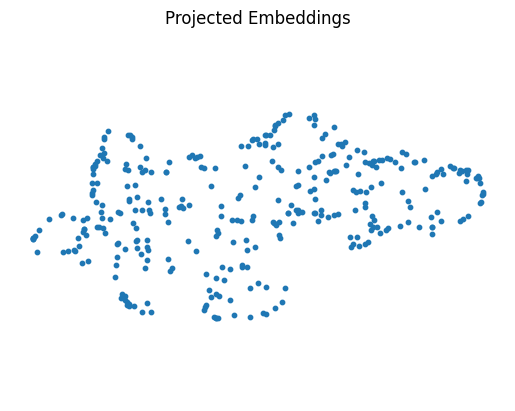

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

## 2.1 Visualize query and results: Relevant results

In [18]:
query = "What is the total revenue?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]
for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

revenue, classified by significant product and service offerings, was
as follows : ( in millions ) year ended june 30, 2022 2021 2020 server
products and cloud services $ 67, 321 $ 52, 589 $ 41, 379 office
products and cloud services 44, 862 39, 872 35, 316 windows 24, 761 22,
488 21, 510 gaming 16, 230 15, 370 11, 575 linkedin 13, 816 10, 289 8,
077 search and news advertising 11, 591 9, 267 8, 524 enterprise
services 7, 407 6, 943 6, 409 devices 6, 991 6, 791 6, 457 other 5, 291
4, 479 3, 768 total $ 198, 270 $ 168, 088 $ 143, 015 we have recast
certain previously reported amounts in the table above to conform to
the way we internally manage and monitor our business.

74 note 13 — unearned revenue unearned revenue by segment was as
follows : ( in millions ) june 30, 2022 2021 productivity and business
processes $ 24, 558 $ 22, 120 intelligent cloud 19, 371 17, 710 more
personal computing 4, 479 4, 311 total $ 48, 408 $ 44, 141 changes in
unearned revenue were as follows : ( in millio

In [19]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.60it/s]


(-3.042022204399109, 9.21355435848236, 3.218625855445862, 8.772371935844422)

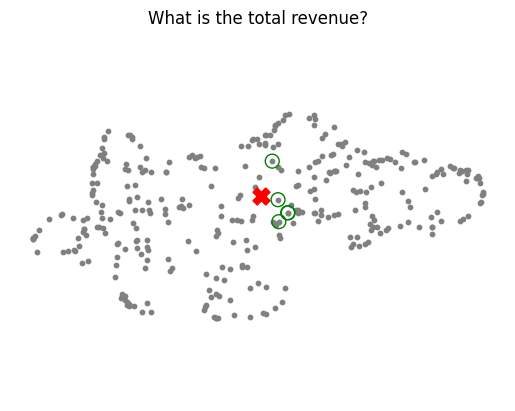

In [20]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

## 2.2 Visualize query and results: Wide spreaded / non relevant results

In [21]:
query = "What has Michael Jordan done for us lately?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

18 total rewards we develop dynamic, sustainable, market - driven, and
strategic programs with the goal of providing a highly differentiated
portfolio to attract, reward, and retain top talent and enable our
employees to thrive. these programs reinforce our culture and values
such as collaboration and growth mindset. managers evaluate and
recommend rewards based on, for example, how well we leverage the work
of others and contribute to the success of our colleagues. we monitor
pay equity and career progress across multiple dimensions. as part of
our effort to promote a one microsoft and inclusive culture, in fiscal
year 2021 we expanded stock eligibility to all microsoft employees as
part of our annual rewards process. this includes all non - exempt and
exempt employees and equivalents across the globe including business
support professionals and datacenter and retail employees. in response

17 as of june 30, 2022, we employed approximately 221, 000 people on a
full - time basis, 122, 

In [22]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57it/s]


(-3.042022204399109, 9.21355435848236, 3.218625855445862, 8.772371935844422)

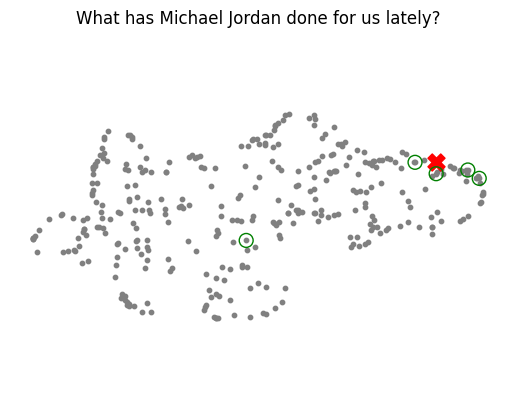

In [23]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')